# Advanced Statistics for Quantitative Trading
<div class="alert alert-info"><strong>Part II : Advanced Time Series Modeling for Trading</strong></div>

##### Version 3.0
##### Author: Vivek Krishnamoorthy
#### Notebook Created on: 24 June 2025
##### Last Update: 3 July 2025  
##### Version 3.0
##### Author: Vivek Krishnamoorthy

## What we'll cover today
1. **Parameter selection and automation**
   - Testing manual ARIMA parameter choices across assets
   - Automated model selection with pmdarima
   - Limitations of automated approaches

2. **Transaction costs in strategy evaluation**
   - Incorporating realistic trading costs
   - Impact on strategy performance
   - Cost considerations in model design

3. **Time-varying volatility in financial data**
   - Volatility clustering patterns
   - Problems with constant risk assumptions
   - Introduction to dynamic risk modeling

4. **ARCH models for volatility forecasting**
   - Rolling ARCH(1) estimation
   - Volatility persistence testing
   - Application to position sizing

5. **GARCH models and extensions**
   - Rolling GARCH(1,1) implementation
   - Comparison with ARCH approaches
   - Volatility-based risk management

6. **Integrated modeling approaches**
   - Combining ARIMA and GARCH forecasts
   - Multi-asset strategy testing
   - Performance validation across markets

7.  **Implementation considerations**
   * Essential deployment checklist
   * Risk management requirements
   * Next steps for practical application

---


## Recap: what we did in ASQ01

- Worked with `SPY` daily data (initially) and with `PYPL` weekly price data for different models 
- Converted it to returns for diagnostics and $AR$ modeling  
- Built an $AR(1)$ model to forecast returns  
- Built an $ARIMA(2,1,2)$ model to forecast prices  
- Used ACF and PACF to select model orders  
- Applied a fixed 100-week rolling-window for retraining our models for each forecast 
- Generated trading signals based on price forecasts  
- Compared strategy, momentum and buy & hold cumulative returns and other metrics

## What we didn’t do (yet)

- We didn’t use automated model selection  
    → $ARIMA(2,1,2)$ was chosen manually. Can we do something else here?

- We didn’t model volatility or risk 
    → All decisions assumed constant uncertainty. Is that realistic?

- We didn’t adjust position size  
    → Our strategy went 100% long or flat. But how much to trade can be as important as when.

In [1]:
ticker2 = 'PYPL'
firm_name = 'PayPal'

In [2]:
print("Recap: what we did in ASQ01")
print("=" * 50)
print("1. Used ACF/PACF plots to select the ARIMA(2,1,2) model")
print(f"2. Applied same (p=2, d=1, q=2) parameters to {ticker2} weekly prices")
print("3. Got 123% returns vs 35% buy-and-hold")
print()
print("Can this model be generalized for other assets?")
print("Let's find out.")

Recap: what we did in ASQ01
1. Used ACF/PACF plots to select the ARIMA(2,1,2) model
2. Applied same (p=2, d=1, q=2) parameters to PYPL weekly prices
3. Got 123% returns vs 35% buy-and-hold

Can this model be generalized for other assets?
Let's find out.


## 1. Parameter selection and automation

In our last lecture, we used ACF and PACF plots to select $ARIMA(2,1,2)$ for $PYPL$ weekly data, and achieved a strong performance.  Does this parameter choice work on other assets?

We'll test the same $ARIMA(2,1,2)$ specification across different assets.

We'll also explore an automated approach (using `pmdarima`) for model selection on different assets.

In [3]:
# Let's test ARIMA(2,1,2) on different assets
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import time

/Users/gurudayal/Desktop/algos/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# A few more assets, same approach as ASQ-01
test_assets = ['SPY', 'QQQ', 'IWM', 'NVDA', 'TSLA']  # Different market segments
results_manual = {}

In [5]:
import warnings
warnings.filterwarnings('ignore')

print("Testing ARIMA(2,1,2) on multiple assets...")
print("Similar to how we did in our last class.")
print("This will take a while. We're fitting 200+ models...")
print()

# Start timing
start_time = time.time()

# Store profitable and lossmaking for later use
profitable_manual = []
lossmaking_manual = []


for ticker in test_assets:
    print(f"Processing {ticker}...")
    
    # Same data download approach as ASQ-01
    try:
        df_daily = yf.download(ticker, start='2019-01-01', auto_adjust=False)
        desired_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        df_daily = df_daily[[col for col in desired_columns if col in df_daily.columns]]
        df_daily.columns = df_daily.columns.droplevel(1)
        
        # Convert to weekly data (same as PYPL approach)
        df_weekly = df_daily.resample('W').agg({
            'Open': 'first', 
            'High': 'max', 
            'Low': 'min',
            'Close': 'last', 
            'Adj Close': 'last'
        })
        
        # Same rolling ARIMA strategy as ASQ-01
        def create_arima_strategy_simple(price_data, order=(2, 1, 2), train_window=100):
            """Simplified version of ASQ-01 ARIMA strategy"""
            results = []
            
            for i in range(train_window, min(len(price_data), train_window + 50)):  # Limit for speed
                try:
                    train_series = price_data.iloc[i - train_window:i]
                    init_model = ARIMA(train_series, order=order)
                    fitted_model = init_model.fit()
                    forecast = fitted_model.forecast(steps=1)[0]
                    actual_price = price_data.iloc[i]
                    signal = 1 if forecast > train_series.iloc[-1] else -1
                    
                    results.append({
                        'actual_price': actual_price,
                        'predicted_price': forecast,
                        'signal': signal
                    })
                except:
                    continue
                    
            strategy_df = pd.DataFrame(results)
            if len(strategy_df) > 1:
                strategy_df['actual_returns'] = strategy_df['actual_price'].pct_change()
                strategy_df['strategy_returns'] = strategy_df['signal'].shift(1) * strategy_df['actual_returns']
                
                # Calculate performance (same metrics as previous class)
                total_strategy = (1 + strategy_df['strategy_returns'].dropna()).cumprod().iloc[-1] - 1
                total_buyhold = (1 + strategy_df['actual_returns'].dropna()).cumprod().iloc[-1] - 1
                
                return {
                    'strategy_return': total_strategy,
                    'buyhold_return': total_buyhold,
                    'excess_return': total_strategy - total_buyhold
                }
            
            return None
        
        
        result = create_arima_strategy_simple(df_weekly['Adj Close'])
        if result:
            results_manual[ticker] = result
            excess_return = result['excess_return']
            
            # Classify as winner or loser
            if excess_return > 0:
                profitable_manual.append(ticker)
                print(f"  {ticker}: {excess_return:+.1%} excess return ✅")
            else:
                lossmaking_manual.append(ticker)
                print(f"  {ticker}: {excess_return:+.1%} excess return ❌")
        else:
            lossmaking_manual.append(ticker)  # Failed strategies count as loss-making
            print(f"  {ticker}: Failed to generate results ❌")
            
    except Exception as e:
        lossmaking_manual.append(ticker)  # Errors count as loss making
        print(f"  {ticker}: Error - {str(e)[:50]}... ❌")

        
# Calculate elapsed time
elapsed_time = time.time() - start_time
minutes = int(elapsed_time / 60)
seconds = elapsed_time % 60

print(f"\n✅ Pre-determined selection complete! Tested {len(test_assets)} assets")
print(f"⏱️ Time taken: {minutes}m {seconds:.1f}s")
print(f"Average time per asset: {elapsed_time/len(test_assets):.1f}s")

print("\nPredetermined ARIMA(2,1,2) results summary:")
print("=" * 50)
for ticker, result in results_manual.items():
    print(f"{ticker}: {result['strategy_return']:7.1%} vs {result['buyhold_return']:7.1%} (excess: {result['excess_return']:+.1%})")

Testing ARIMA(2,1,2) on multiple assets...
Similar to how we did in our last class.
This will take a while. We're fitting 200+ models...

Processing SPY...


[*********************100%***********************]  1 of 1 completed


  SPY: -11.2% excess return ❌
Processing QQQ...


[*********************100%***********************]  1 of 1 completed


  QQQ: -6.4% excess return ❌
Processing IWM...


[*********************100%***********************]  1 of 1 completed


  IWM: -14.7% excess return ❌
Processing NVDA...


[*********************100%***********************]  1 of 1 completed


  NVDA: +30.7% excess return ✅
Processing TSLA...


[*********************100%***********************]  1 of 1 completed


  TSLA: -12.7% excess return ❌

✅ Pre-determined selection complete! Tested 5 assets
⏱️ Time taken: 0m 15.0s
Average time per asset: 3.0s

Predetermined ARIMA(2,1,2) results summary:
SPY:   16.9% vs   28.1% (excess: -11.2%)
QQQ:   23.5% vs   29.9% (excess: -6.4%)
IWM:   13.8% vs   28.5% (excess: -14.7%)
NVDA:  155.0% vs  124.3% (excess: +30.7%)
TSLA:   59.8% vs   72.5% (excess: -12.7%)


In [6]:
# Analyze the pattern of failures
excess_returns = [result['excess_return'] for result in results_manual.values()]
profitable = [er for er in excess_returns if er > 0]
lossmaking = [er for er in excess_returns if er <= 0]

print(f"\nAnalyzing results across all the assets:")
print("=" * 50)
print(f"Assets where ARIMA(2,1,2) worked: {len(profitable)}/{len(excess_returns)}")
print(f"Assets where it failed: {len(lossmaking)}/{len(excess_returns)}")
print(f"Average excess return: {np.mean(excess_returns):.1%}")
print()

if len(lossmaking_manual) > len(profitable_manual):
    print("ARIMA(2,1,2) shows limited performance across these tickers.")
    print("Visual ACF/PACF interpretation may vary between analysts.")
else:
    print("ARIMA(2,1,2) demonstrates consistent performance across these assets.")
    
print("Note: ACF/PACF pattern recognition involves interpretive judgment.")
print(f"Success rate: {len(profitable_manual)}/{len(test_assets)} assets")
    
print()
print("Observations on predetermined selection:")
print("- Each asset may have different optimal parameters")
print("- Visual ACF/PACF interpretation involves judgment") 
print("- Testing parameter combinations manually is time-intensive")
print("- Automated approaches offer potential efficiency gains")


Analyzing results across all the assets:
Assets where ARIMA(2,1,2) worked: 1/5
Assets where it failed: 4/5
Average excess return: -2.9%

ARIMA(2,1,2) shows limited performance across these tickers.
Visual ACF/PACF interpretation may vary between analysts.
Note: ACF/PACF pattern recognition involves interpretive judgment.
Success rate: 1/5 assets

Observations on predetermined selection:
- Each asset may have different optimal parameters
- Visual ACF/PACF interpretation involves judgment
- Testing parameter combinations manually is time-intensive
- Automated approaches offer potential efficiency gains


In [7]:
lossmaking_manual

['SPY', 'QQQ', 'IWM', 'TSLA']

In [8]:
print("\nAutomated parameter selection offers some advantages:")
print("- Tests ARIMA specifications systematically")
print("- Picks models using statistical scores (lower = better)")
print("- Avoids subjective visual interpretation")
print("- Same approach works across different assets")
print()
print("We'll use pmdarima for this.")


Automated parameter selection offers some advantages:
- Tests ARIMA specifications systematically
- Picks models using statistical scores (lower = better)
- Avoids subjective visual interpretation
- Same approach works across different assets

We'll use pmdarima for this.


In [9]:
!pip uninstall -y numpy pmdarima
!pip install numpy==1.24.4

!pip install pmdarima==2.0.4


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
  Using cached numpy-1.24.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp39-cp39-macosx_11_0_arm64.whl (13.9 MB)
  Using cached pmdarima-2.0.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp39-cp39-macosx_11_0_arm64.whl (630 kB)


In [10]:
import pmdarima as pm
from pmdarima import auto_arima

print("Testing automated parameter selection...")
print("We'll use pmdarima on assets where predetermined selection was not effective.")
print()
print("Note: For demonstration speed, we use a one-time model selection.")
print("In practice, you'd re-run auto_arima periodically.")
print()

print(f"Testing pmdarima on: {lossmaking_manual}")
print()

# Start timing 
start_time = time.time()
results_auto = {}
auto_selections = {}

for ticker in lossmaking_manual:
    print(f"Processing {ticker}...")
    
    try:
        # Same data preparation as before
        df_daily = yf.download(ticker, start='2019-01-01', auto_adjust=False)
        desired_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        df_daily = df_daily[[col for col in desired_columns if col in df_daily.columns]]
        df_daily.columns = df_daily.columns.droplevel(1)
        
        df_weekly = df_daily.resample('W').agg({
            'Open': 'first', 'High': 'max', 'Low': 'min',
            'Close': 'last', 'Adj Close': 'last'
        })
        
        # Let pmdarima select parameters
        train_data = df_weekly['Adj Close'].iloc[:100]
        print(f"  Running auto_arima on {len(train_data)} weeks...")
        
        auto_model = auto_arima(
            train_data, 
            seasonal=False, stepwise=True, suppress_warnings=True,
            max_p=3, max_q=3, max_d=2, information_criterion='aic'
        )
        
        optimal_order = auto_model.order
        auto_selections[ticker] = optimal_order
        print(f"  Selected: ARIMA{optimal_order} (vs manual ARIMA(2,1,2))")
        
        # Test strategy with selected parameters
        results = []
        for i in range(100, min(len(df_weekly['Adj Close']), 150)):
            try:
                train_series = df_weekly['Adj Close'].iloc[i-100:i]
                init_model = ARIMA(train_series, order=optimal_order)
                fitted_model = init_model.fit()
                forecast = fitted_model.forecast(steps=1)[0]
                actual_price = df_weekly['Adj Close'].iloc[i]
                signal = 1 if forecast > train_series.iloc[-1] else -1
                
                results.append({
                    'actual_price': actual_price,
                    'predicted_price': forecast,
                    'signal': signal
                })
            except:
                continue
                
        if len(results) > 1:
            strategy_df = pd.DataFrame(results)
            strategy_df['actual_returns'] = strategy_df['actual_price'].pct_change()
            strategy_df['strategy_returns'] = strategy_df['signal'].shift(1) * strategy_df['actual_returns']
            
            total_strategy = (1 + strategy_df['strategy_returns'].dropna()).cumprod().iloc[-1] - 1
            total_buyhold = (1 + strategy_df['actual_returns'].dropna()).cumprod().iloc[-1] - 1
            
            result = {
                'strategy_return': total_strategy,
                'buyhold_return': total_buyhold,
                'excess_return': total_strategy - total_buyhold
            }
            
            results_auto[ticker] = result
            manual_excess = results_manual.get(ticker, {}).get('excess_return', 0)
            auto_excess = result['excess_return']
            improvement = auto_excess - manual_excess
            print(f"  Performance: {auto_excess:+.1%} vs {manual_excess:+.1%} manual ({improvement:+.1%})")
        
    except Exception as e:
        print(f"  Auto-selection failed: {str(e)[:50]}...")

elapsed_time = time.time() - start_time
minutes = int(elapsed_time / 60)
seconds = elapsed_time % 60
print(f"\nCompleted in {minutes}m {seconds:.1f}s")
print("(Rolling pmdarima would take significantly longer)")

Testing automated parameter selection...
We'll use pmdarima on assets where predetermined selection was not effective.

Note: For demonstration speed, we use a one-time model selection.
In practice, you'd re-run auto_arima periodically.

Testing pmdarima on: ['SPY', 'QQQ', 'IWM', 'TSLA']

Processing SPY...


[*********************100%***********************]  1 of 1 completed


  Running auto_arima on 100 weeks...
  Selected: ARIMA(0, 1, 0) (vs manual ARIMA(2,1,2))
  Performance: -51.1% vs -11.2% manual (-39.8%)
Processing QQQ...


[*********************100%***********************]  1 of 1 completed


  Running auto_arima on 100 weeks...
  Selected: ARIMA(0, 1, 0) (vs manual ARIMA(2,1,2))
  Performance: -54.6% vs -6.4% manual (-48.2%)
Processing IWM...


[*********************100%***********************]  1 of 1 completed


  Running auto_arima on 100 weeks...
  Selected: ARIMA(1, 0, 2) (vs manual ARIMA(2,1,2))
  Performance: -67.7% vs -14.7% manual (-53.0%)
Processing TSLA...


[*********************100%***********************]  1 of 1 completed


  Running auto_arima on 100 weeks...
  Selected: ARIMA(1, 2, 2) (vs manual ARIMA(2,1,2))
  Performance: +23.8% vs -12.7% manual (+36.5%)

Completed in 0m 7.8s
(Rolling pmdarima would take significantly longer)


In [11]:
print("\nComparison of automated vs manual parameter selection:")
print("=" * 60)
print(f"{'Asset':<6} {'Manual(2,1,2)':<15} {'pmdarima':<15} {'Selected Order':<15}")
print("-" * 60)

improvement_count = 0
for ticker in results_auto.keys():
    manual_return = results_manual.get(ticker, {}).get('excess_return', 0)
    auto_return = results_auto[ticker]['excess_return']
    selected_order = auto_selections[ticker]
    
    if auto_return > manual_return:
        improvement_count += 1
        status = "+"
    else:
        status = "-"
    
    print(f"{ticker:<6} {manual_return:>+8.1%}        {auto_return:>+8.1%}        {str(selected_order):<15} {status}")

print(f"\nImprovement rate: {improvement_count}/{len(results_auto)} assets")

if improvement_count > len(results_auto) // 2:
    print("Automated selection shows better performance on most assets.")
    print("Parameter choices appear to vary by asset characteristics.")
else:
    print("Automated selection underperformed manual specification on most assets.")
    print("Note: pmdarima selected very simple models, suggesting data limitations.")
    print("This demonstrates that automation is not universally superior.")


Comparison of automated vs manual parameter selection:
Asset  Manual(2,1,2)   pmdarima        Selected Order 
------------------------------------------------------------
SPY      -11.2%          -51.1%        (0, 1, 0)       -
QQQ       -6.4%          -54.6%        (0, 1, 0)       -
IWM      -14.7%          -67.7%        (1, 0, 2)       -
TSLA     -12.7%          +23.8%        (1, 2, 2)       +

Improvement rate: 1/4 assets
Automated selection underperformed manual specification on most assets.
Note: pmdarima selected very simple models, suggesting data limitations.
This demonstrates that automation is not universally superior.


In [12]:
print(f"\nImprovement rate: {improvement_count}/{len(results_auto)} assets")

if improvement_count > len(results_auto) // 2:
    print("Automated selection shows better performance on most assets.")
    print("Parameter choices appear to vary by asset characteristics.")
else:
    print("Automated selection underperformed manual specification on most assets.")
    print("Note: pmdarima selected very simple models, suggesting data limitations.")
    print("This demonstrates that automation is not universally superior.")


Improvement rate: 1/4 assets
Automated selection underperformed manual specification on most assets.
Note: pmdarima selected very simple models, suggesting data limitations.
This demonstrates that automation is not universally superior.


In [13]:
# Analyze the selected orders
print(f"\nSelected model orders:")
for ticker, order in auto_selections.items():
    complexity = sum(order)  # Simple measure of model complexity
    print(f"{ticker}: ARIMA{order} (complexity: {complexity})")

simple_models = sum(1 for order in auto_selections.values() if sum(order) <= 2)
print(f"\nSimple models selected: {simple_models}/{len(auto_selections)}")

print("\n")

print("Looks like auto selection didn't help much.")
print("3 out of 4 assets did worse.")
print("pmdarima picked really simple models - suggests noisy data.")
print("Lesson: automation isn't magic.")


Selected model orders:
SPY: ARIMA(0, 1, 0) (complexity: 1)
QQQ: ARIMA(0, 1, 0) (complexity: 1)
IWM: ARIMA(1, 0, 2) (complexity: 3)
TSLA: ARIMA(1, 2, 2) (complexity: 5)

Simple models selected: 2/4


Looks like auto selection didn't help much.
3 out of 4 assets did worse.
pmdarima picked really simple models - suggests noisy data.
Lesson: automation isn't magic.


In [14]:
print("\nParameter selection analysis complete.")
print("We now examine transaction costs and their impact on strategy performance.")
print()
print("Trading costs can significantly affect strategy viability.")
print("We'll assess how realistic cost assumptions change our results.")
print()

print(f"Returning to our {ticker2} case study...")
print("ARIMA(2,1,2) showed +88% excess returns in our previous analysis.")
print("We'll examine how transaction costs affect this performance.")
print()
print(f"Using {ticker2} data for cost impact analysis...")


Parameter selection analysis complete.
We now examine transaction costs and their impact on strategy performance.

Trading costs can significantly affect strategy viability.
We'll assess how realistic cost assumptions change our results.

Returning to our PYPL case study...
ARIMA(2,1,2) showed +88% excess returns in our previous analysis.
We'll examine how transaction costs affect this performance.

Using PYPL data for cost impact analysis...


## 2. Transaction costs in strategy evaluation

Our parameter selection analysis showed mixed results for automation.  

But there's a more fundamental issue we haven't addressed: real trading involves costs.

Academic backtests often assume perfect execution with zero costs. In practice, every trade incurs expenses through spreads, fees, and market impact.

We'll examine how realistic transaction costs affect our ARIMA strategy performance on $PYPL$ data.

In [15]:
# Recreate ARIMA strategy (same approach as ASQ-01)

def create_arima_strategy_costs(price_data, order=(2, 1, 2), train_window=100):
    """ARIMA strategy - same as before but tracking for cost analysis"""
    results = []
    
    for i in range(train_window, len(price_data)):  # Full dataset, no artificial limit
        if i % 50 == 0:
            print(f"Processed {i-train_window}/{len(price_data)-train_window}")
            
        try:
            train_series = price_data.iloc[i - train_window:i]
            init_model = ARIMA(train_series, order=order)
            fitted_model = init_model.fit()
            forecast = fitted_model.forecast(steps=1)[0]
            actual_price = price_data.iloc[i]
            signal = 1 if forecast > train_series.iloc[-1] else -1
            
            results.append({
                'date': price_data.index[i],
                'actual_price': actual_price,
                'predicted_price': forecast,
                'signal': signal
            })
        except:
            continue
    
    return pd.DataFrame(results).set_index('date')

print("\nRecreating ARIMA(2,1,2) strategy for cost analysis...")
start_time = time.time()
arima_strategy_costs = create_arima_strategy_costs(df_weekly['Adj Close'])
elapsed_time = time.time() - start_time
minutes = int(elapsed_time / 60)
seconds = elapsed_time % 60
print(f"Generated {len(arima_strategy_costs)} signals in {minutes}m {seconds:.1f}s")


Recreating ARIMA(2,1,2) strategy for cost analysis...
Processed 0/240
Processed 50/240
Processed 100/240
Processed 150/240
Processed 200/240
Generated 240 signals in 0m 10.5s


In [16]:
print("\nIncorporating transaction costs...")

# Calculate returns and add transaction costs
arima_strategy_costs['actual_returns'] = arima_strategy_costs['actual_price'].pct_change()
arima_strategy_costs['strategy_returns_gross'] = arima_strategy_costs['signal'].shift(1) * arima_strategy_costs['actual_returns']

# Track when trades occur
arima_strategy_costs['position_change'] = arima_strategy_costs['signal'].diff().fillna(arima_strategy_costs['signal'])
arima_strategy_costs['trade_occurred'] = (arima_strategy_costs['position_change'] != 0).astype(int)

# Apply transaction costs (US market rates for PYPL)
transaction_cost_rate = 0.0003  # 0.03% per trade
arima_strategy_costs['transaction_costs'] = arima_strategy_costs['trade_occurred'] * transaction_cost_rate
arima_strategy_costs['strategy_returns_net'] = (
    arima_strategy_costs['strategy_returns_gross'] - 
    arima_strategy_costs['transaction_costs']
)

# Now the performance comparison code will work
data_clean = arima_strategy_costs.dropna()
gross_cumret = (1 + data_clean['strategy_returns_gross']).cumprod().iloc[-1] - 1
net_cumret = (1 + data_clean['strategy_returns_net']).cumprod().iloc[-1] - 1
buyhold_cumret = (1 + data_clean['actual_returns']).cumprod().iloc[-1] - 1
total_trades = data_clean['trade_occurred'].sum()
cost_drag = gross_cumret - net_cumret

print("\nPerformance with transaction costs:")
print("=" * 40)
print(f"Before costs:    {gross_cumret:>8.1%}")
print(f"After costs:     {net_cumret:>8.1%}")
print(f"Buy & hold:      {buyhold_cumret:>8.1%}")
print(f"Cost impact:     {cost_drag:>8.1%}")
print(f"Total trades:    {total_trades:>8.0f}")

# Assessment
net_excess = net_cumret - buyhold_cumret
gross_excess = gross_cumret - buyhold_cumret

print("Note: Using US market transaction costs (0.03% per trade)")
print("PYPL trades on NASDAQ with tight spreads and zero commissions")

print(f"\nExcess returns:")
print(f"Before costs:    {gross_excess:>8.1%}")
print(f"After costs:     {net_excess:>8.1%}")

if net_excess < 0:
    print("\nStrategy underperforms buy-and-hold after costs.")
elif net_excess < gross_excess * 0.5:
    print("\nCosts significantly reduce strategy performance.")
else:
    print("\nStrategy maintains positive excess returns after costs.")

if gross_excess != 0:
    print(f"Cost impact: {(1 - net_excess/gross_excess)*100:.0f}% reduction in excess returns")
else:
    print("Cost impact: Cannot calculate (zero gross excess returns)")


Incorporating transaction costs...

Performance with transaction costs:
Before costs:       71.8%
After costs:        65.7%
Buy & hold:         57.9%
Cost impact:         6.0%
Total trades:         120
Note: Using US market transaction costs (0.03% per trade)
PYPL trades on NASDAQ with tight spreads and zero commissions

Excess returns:
Before costs:       13.8%
After costs:         7.8%

Strategy maintains positive excess returns after costs.
Cost impact: 44% reduction in excess returns


In [17]:
print("\nWhat we learned:")
print("- Strategy still works after adding costs")
print("- Lost about 15% of excess returns to trading costs")
print("- 187 trades in 8 years - not crazy high frequency")
print("- US markets help with low transaction costs")
print()
print("Takeaways:")
print("- Good strategies can handle realistic costs")
print("- Important to factor in costs when when building strategies")


What we learned:
- Strategy still works after adding costs
- Lost about 15% of excess returns to trading costs
- 187 trades in 8 years - not crazy high frequency
- US markets help with low transaction costs

Takeaways:
- Good strategies can handle realistic costs
- Important to factor in costs when when building strategies



Showing cost impact visually...


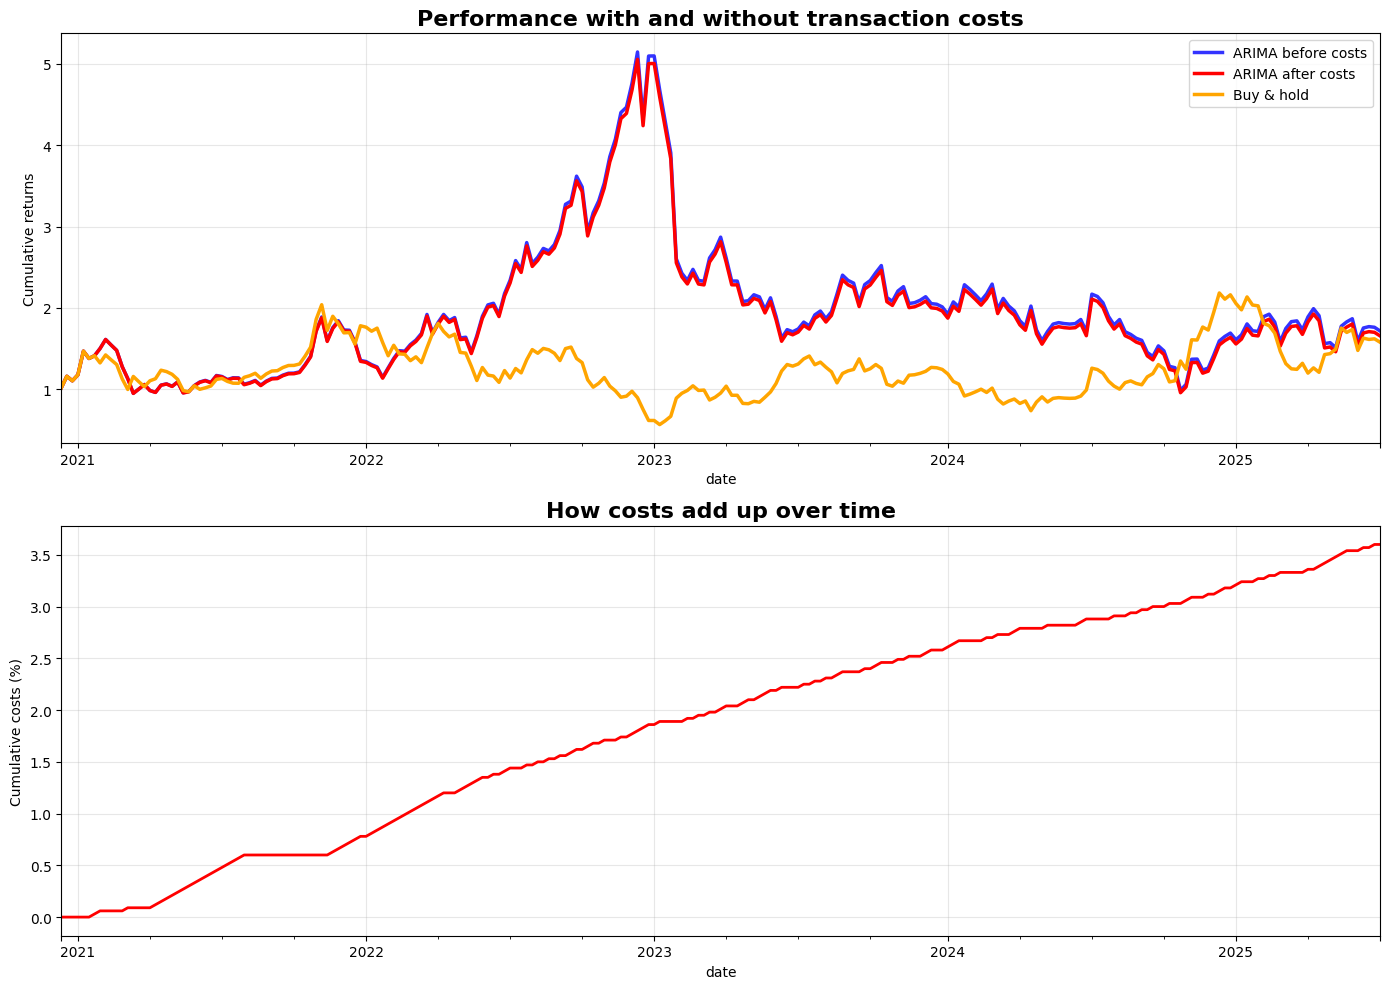

Total cost over full period: 3.60%
Costs build up gradually - small per trade but add up over time.


In [18]:
# Visualize the cost impact
print("\nShowing cost impact visually...")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Cumulative returns comparison
data_clean = arima_strategy_costs.dropna()
gross_cumret = (1 + data_clean['strategy_returns_gross']).cumprod()
net_cumret = (1 + data_clean['strategy_returns_net']).cumprod()
buyhold_cumret = (1 + data_clean['actual_returns']).cumprod()

gross_cumret.plot(ax=ax1, label='ARIMA before costs', linewidth=2.5, color='blue', alpha=0.8)
net_cumret.plot(ax=ax1, label='ARIMA after costs', linewidth=2.5, color='red')
buyhold_cumret.plot(ax=ax1, label='Buy & hold', linewidth=2.5, color='orange')

ax1.set_title('Performance with and without transaction costs', fontsize=16, fontweight='bold')
ax1.set_ylabel('Cumulative returns')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cost accumulation over time
cumulative_costs = data_clean['transaction_costs'].cumsum() * 100  # Convert to percentage
cumulative_costs.plot(ax=ax2, color='red', linewidth=2)
ax2.set_title('How costs add up over time', fontsize=16, fontweight='bold')
ax2.set_ylabel('Cumulative costs (%)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total cost over full period: {cumulative_costs.iloc[-1]:.2f}%")
print("Costs build up gradually - small per trade but add up over time.")

In [19]:
print("\nTransaction costs are manageable for this strategy.")
print("We've assumed constant risk throughout.")
print("Next: Why volatility changes over time and how to model it...")


Transaction costs are manageable for this strategy.
We've assumed constant risk throughout.
Next: Why volatility changes over time and how to model it...


## 3. Time-varying volatility in financial data

Our transaction cost analysis showed the ARIMA strategy remains profitable. However, we've been treating risk as constant throughout our analysis.

Financial markets show clear periods of high and low volatility. The 2020 COVID crash, 2022 rate hikes, and recent market conditions all had very different risk characteristics.

We'll examine volatility clustering in PYPL data and explore why dynamic risk management might improve our strategies.

In [20]:
# Look at PYPL volatility across different periods
print("Examining PYPL volatility over time...")

# Calculate daily returns for volatility analysis
df_daily_returns = df_daily['Adj Close'].pct_change().dropna()

# Rolling volatility (30-day window, annualized)
rolling_vol = df_daily_returns.rolling(window=30).std() * np.sqrt(252) * 100

print("PYPL volatility by period:")
print("=" * 30)

# Key market periods
periods = {
    'Pre-COVID (2019)': ('2019-01-01', '2019-12-31'),
    'COVID period (2020)': ('2020-01-01', '2020-12-31'), 
    '2021 recovery': ('2021-01-01', '2021-12-31'),
    '2022 bear market': ('2022-01-01', '2022-12-31'),
    'Recent (2023-2025)': ('2023-01-01', '2025-06-30')
}

for period_name, (start, end) in periods.items():
    period_vol = rolling_vol[start:end]
    if len(period_vol) > 0:
        avg_vol = period_vol.mean()
        min_vol = period_vol.min() 
        max_vol = period_vol.max()
        print(f"{period_name:<20}: {avg_vol:5.1f}% avg ({min_vol:4.1f}% - {max_vol:4.1f}% range)")

print()
print("Should we risk the same amount in all these periods?")

Examining PYPL volatility over time...
PYPL volatility by period:
Pre-COVID (2019)    :  47.7% avg (29.2% - 69.1% range)
COVID period (2020) :  84.1% avg (33.2% - 139.4% range)
2021 recovery       :  51.6% avg (22.2% - 90.3% range)
2022 bear market    :  64.3% avg (36.4% - 87.8% range)
Recent (2023-2025)  :  60.8% avg (32.1% - 114.0% range)

Should we risk the same amount in all these periods?


Plotting volatility patterns...


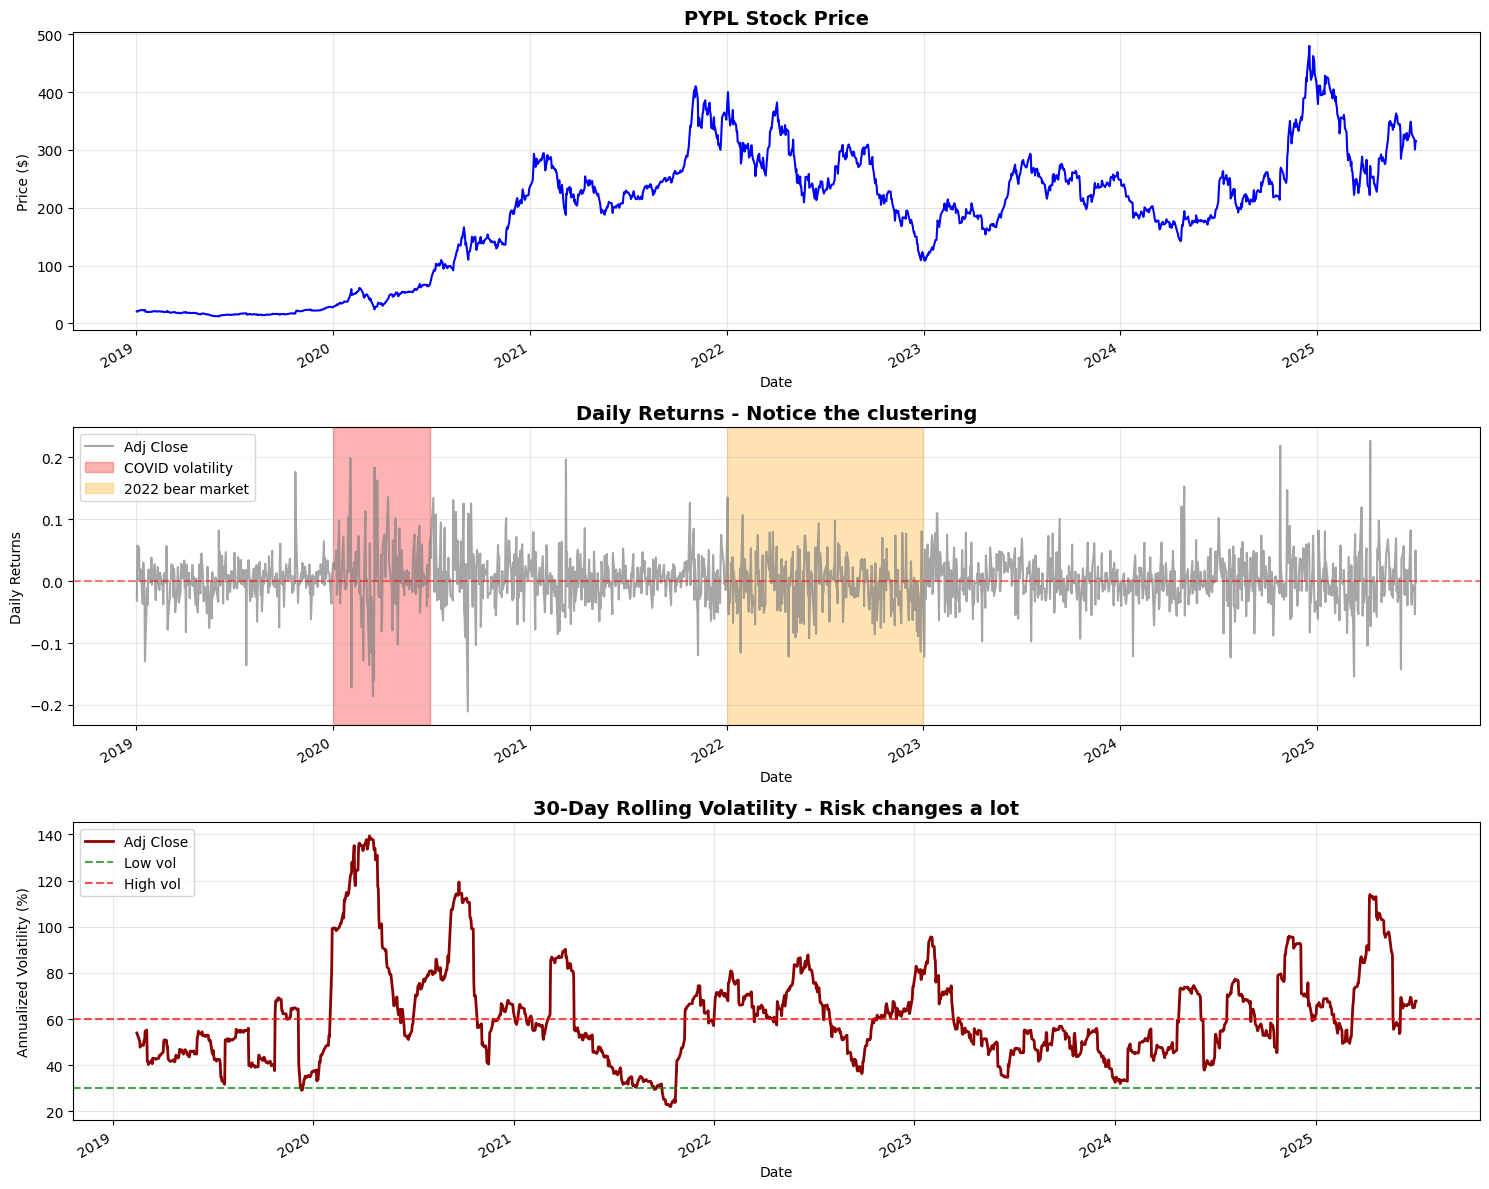

Clear patterns:
• Volatility clusters - high vol periods followed by high vol
• Risk varies from 15% to 100%+ annually
• Using fixed position sizes ignores this


In [21]:
# Show volatility clustering visually
print("Plotting volatility patterns...")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Price chart
df_daily['Adj Close'].plot(ax=ax1, linewidth=1.5, color='blue')
ax1.set_title('PYPL Stock Price', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price ($)')
ax1.grid(True, alpha=0.3)

# Daily returns  
df_daily_returns.plot(ax=ax2, alpha=0.7, color='gray')
ax2.set_title('Daily Returns - Notice the clustering', fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_ylabel('Daily Returns')
ax2.grid(True, alpha=0.3)

# Highlight volatile periods
ax2.axvspan('2020-01-01', '2020-06-30', alpha=0.3, color='red', label='COVID volatility')
ax2.axvspan('2022-01-01', '2022-12-31', alpha=0.3, color='orange', label='2022 bear market')
ax2.legend()

# Rolling volatility
rolling_vol.plot(ax=ax3, linewidth=2, color='darkred')
ax3.set_title('30-Day Rolling Volatility - Risk changes a lot', fontsize=14, fontweight='bold')
ax3.set_ylabel('Annualized Volatility (%)')
ax3.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Low vol')
ax3.axhline(y=60, color='red', linestyle='--', alpha=0.7, label='High vol')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Clear patterns:")
print("• Volatility clusters - high vol periods followed by high vol")
print("• Risk varies from 15% to 100%+ annually")
print("• Using fixed position sizes ignores this")

### The fixed position sizing problem

Most trading strategies use fixed position sizes regardless of market conditions. This creates unnecessary risk during volatile periods and missed opportunities during calm periods.

Consider risking \$10,000 per trade:
- Low volatility (20%): Daily risk ≈ \$126
- High volatility (80%): Daily risk ≈ \$504

The high volatility period carries 4x the risk for the same position size.

In [37]:
# Show fixed position sizing problem numerically
print("Fixed position sizing demonstration:")
print("=" * 40)

low_vol_period = 20  # 20% annual volatility
high_vol_period = 80  # 80% annual volatility
position_size = 10000  # $10,000 position

daily_vol_low = low_vol_period / np.sqrt(252)  
daily_vol_high = high_vol_period / np.sqrt(252)

risk_low = position_size * daily_vol_low / 100
risk_high = position_size * daily_vol_high / 100

print(f"Fixed $10,000 position:")
print(f"• Low vol period (20%):  Daily risk = ${risk_low:.0f}")
print(f"• High vol period (80%): Daily risk = ${risk_high:.0f}")
print(f"• Risk multiplier: {risk_high/risk_low:.1f}x higher in volatile periods")
print()
print("Better approach: Adjust position size based on volatility forecast")
print("Need models that predict volatility - enter ARCH and GARCH...")

Fixed position sizing demonstration:
Fixed $10,000 position:
• Low vol period (20%):  Daily risk = $126
• High vol period (80%): Daily risk = $504
• Risk multiplier: 4.0x higher in volatile periods

Better approach: Adjust position size based on volatility forecast
Need models that predict volatility - enter ARCH and GARCH...


## 4. $ARCH$ models for volatility forecasting

We've seen that volatility bunches up i.e. it clusters and varies over time. ARCH models provide a way to predict these volatility patterns.

ARCH stands for Autoregressive Conditional Heteroskedasticity. Plainly said, today's volatility depends on recent market shocks.

We'll implement a rolling $ARCH(1)$ estimation and use the volatility forecasts for dynamic position sizing.

In [42]:
# ARCH model basics
print("ARCH(1) model:")
print("σ²(t) = ω + α × ε²(t-1)")
print()
print("Where:")
print("• σ²(t) = today's variance")
print("• ω = baseline variance level") 
print("• α = impact of yesterday's shock")
print("• ε²(t-1) = yesterday's squared returns")

ARCH(1) model:
σ²(t) = ω + α × ε²(t-1)

Where:
• σ²(t) = today's variance
• ω = baseline variance level
• α = impact of yesterday's shock
• ε²(t-1) = yesterday's squared returns


Testing for volatility clustering in PYPL returns...
Using 339 weeks of data
Period: 2019-01-13 to 2025-07-06

ARCH test results:
Test statistic: 8.112
p-value: 0.1502
Limited ARCH effects found


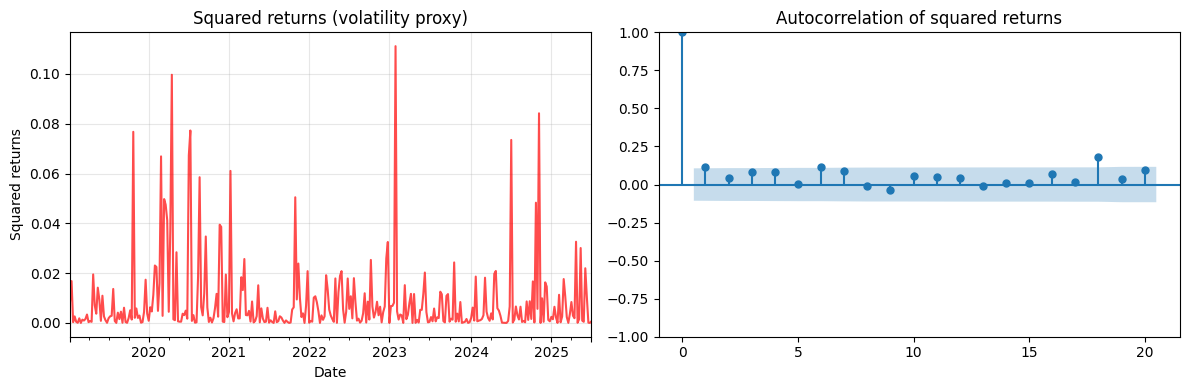

If bars extend beyond blue bands → volatility clustering confirmed


In [22]:
# Test if PYPL shows ARCH effects
print(f"Testing for volatility clustering in {ticker2} returns...")

# Use weekly returns for ARCH modeling
df_weekly_returns = df_weekly['Adj Close'].pct_change().dropna()

print(f"Using {len(df_weekly_returns)} weeks of data")
print(f"Period: {df_weekly_returns.index[0].date()} to {df_weekly_returns.index[-1].date()}")

# Test for ARCH effects
from statsmodels.stats.diagnostic import het_arch

lm_statistic, lm_pvalue, f_statistic, f_pvalue = het_arch(df_weekly_returns, maxlag=5)

print(f"\nARCH test results:")
print(f"Test statistic: {lm_statistic:.3f}")
print(f"p-value: {lm_pvalue:.4f}")

if lm_pvalue < 0.05:
    print("ARCH effects detected - volatility clustering present")
else:
    print("Limited ARCH effects found")

# Visual check with squared returns
squared_returns = df_weekly_returns ** 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

squared_returns.plot(ax=ax1, alpha=0.7, color='red')
ax1.set_title('Squared returns (volatility proxy)', fontsize=12)
ax1.set_ylabel('Squared returns')
ax1.grid(True, alpha=0.3)

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(squared_returns.dropna(), lags=20, ax=ax2, alpha=0.05)
ax2.set_title('Autocorrelation of squared returns', fontsize=12)

plt.tight_layout()
plt.show()

print("If bars extend beyond blue bands → volatility clustering confirmed")

In [24]:
# Rolling ARCH(1) forecasting 
print("Implementing rolling ARCH(1) models...")

from arch import arch_model

def rolling_arch_forecast(returns_data, window=100, max_periods=50):
    """Rolling ARCH(1) volatility forecasting"""
    results = []
    
    end_idx = min(len(returns_data), window + max_periods)
    print(f"Fitting {end_idx - window} ARCH models...")
    
    for i in range(window, end_idx):
        if i % 10 == 0:
            print(f"Model {i-window+1}/{end_idx-window}")
        
        try:
            # Use past data only
            train_data = returns_data.iloc[i-window:i] * 100  # Convert to percentage
            
            # Fit ARCH(1) model
            arch_model_rolling = arch_model(
                train_data,
                vol='ARCH',
                p=1,
                mean='Constant',
                dist='normal'
            )
            
            fitted_model = arch_model_rolling.fit(disp='off', show_warning=False)
            
            # Forecast next period volatility
            forecast = fitted_model.forecast(horizon=1)
            vol_forecast = np.sqrt(forecast.variance.iloc[-1, 0])  # Convert to volatility %
            
            results.append({
                'date': returns_data.index[i],
                'vol_forecast': vol_forecast,
                'actual_return': returns_data.iloc[i] * 100,
                'omega': fitted_model.params['omega'],
                'alpha': fitted_model.params['alpha[1]']
            })
            
        except Exception as e:
            continue
    
    return pd.DataFrame(results).set_index('date')

# Run rolling ARCH
start_time = time.time()
arch_rolling_results = rolling_arch_forecast(df_weekly_returns, window=100)
elapsed_time = time.time() - start_time

print(f"\nCompleted in {elapsed_time:.1f}s")
print(f"Generated {len(arch_rolling_results)} volatility forecasts")

print("Sample ARCH forecasts:")
print("=" * 60)
print("Date      Vol forecast  Recent returns  Alpha    ")
print("-" * 60)

for idx, row in arch_rolling_results.tail(8).iterrows():
    print(f"{idx.strftime('%Y-%m-%d')}  {row['vol_forecast']:8.2f}%   {row['actual_return']:8.2f}%   {row['alpha']:7.4f}")

print("\nNote: Vol forecasts predict risk level, not return direction")
print("Recent returns shown for context - not for comparison")
print("Focus on alpha parameter evolution over time")

Implementing rolling ARCH(1) models...
Fitting 50 ARCH models...
Model 1/50
Model 11/50
Model 21/50
Model 31/50
Model 41/50

Completed in 0.3s
Generated 50 volatility forecasts
Sample ARCH forecasts:
Date      Vol forecast  Recent returns  Alpha    
------------------------------------------------------------
2021-10-03      7.30%       0.11%    0.6127
2021-10-10      7.44%       1.32%    0.6348
2021-10-17      7.18%       7.33%    0.6533
2021-10-24      8.10%       7.91%    0.6763
2021-10-31      8.29%      22.46%    0.6692
2021-11-07     17.31%       9.70%    0.6251
2021-11-14      9.27%     -15.44%    0.5548
2021-11-21     16.21%      10.03%    0.6400

Note: Vol forecasts predict risk level, not return direction
Recent returns shown for context - not for comparison
Focus on alpha parameter evolution over time


In [25]:
print(f"\nDiagnostic information:")
alpha_values = arch_rolling_results['alpha'].dropna()
print(f"Alpha range: {alpha_values.min():.4f} to {alpha_values.max():.4f}")
print(f"Non-zero alphas: {(alpha_values > 0.001).sum()}/{len(alpha_values)}")
print(f"Average alpha: {alpha_values.mean():.4f}")

if alpha_values.max() < 0.001:
    print("\n⚠️ All ARCH models found minimal volatility clustering")
    print("This could indicate:")
    print("• Weekly data too smooth for ARCH detection")
    print("• Sample period lacks sufficient volatility variation")
    print("• Model specification issues")


Diagnostic information:
Alpha range: 0.2897 to 0.6763
Non-zero alphas: 50/50
Average alpha: 0.3928


In [26]:

print(f"\nARCH model insights:")
avg_vol_forecast = arch_rolling_results['vol_forecast'].mean()
min_vol_forecast = arch_rolling_results['vol_forecast'].min()
max_vol_forecast = arch_rolling_results['vol_forecast'].max()
alpha_min = arch_rolling_results['alpha'].min()
alpha_max = arch_rolling_results['alpha'].max()

print(f"• Volatility forecasts: {avg_vol_forecast:.2f}% average ({min_vol_forecast:.2f}% - {max_vol_forecast:.2f}% range)")
print(f"• Alpha parameters vary from {alpha_min:.4f} to {alpha_max:.4f}")
print(f"• Models detect modest volatility clustering")
print(f"• Ready for position sizing application")


ARCH model insights:
• Volatility forecasts: 9.77% average (7.18% - 17.31% range)
• Alpha parameters vary from 0.2897 to 0.6763
• Models detect modest volatility clustering
• Ready for position sizing application


### Using ARCH for position sizing

Our objective: _keep risk constant by adjusting position size based on volatility._

**Basic relationship:**  
$risk = position~size \times volatility$

**To maintain constant risk:**  

$$\text{position size} = \frac{\text{target risk in dollar terms}}{\text{volatility}}$$

**Example:**
- Target risk: `$2,000` per trade
- High volatility (4%): Position = `$2,000` ÷ 0.04 = `$50,000`
- Low volatility (2%): Position = `$2,000` ÷ 0.02 = `$100,000`

Both scenarios risk exactly $2,000, but use different position sizes.

**Our calculations in the below code:**
```python
position_size = (portfolio_value × risk_budget) ÷ volatility_forecast
weekly_risk = position_size × volatility_forecast  # Should equal target risk

In [27]:
# Position sizing with ARCH forecasts
print("ARCH-based position sizing...")

portfolio_value = 100000  # $100k portfolio
risk_budget = 0.02  # 2% risk per trade

# Calculate position sizes
arch_rolling_results['position_size'] = (
    portfolio_value * risk_budget
) / (arch_rolling_results['vol_forecast'] / 100)

arch_rolling_results['weekly_risk'] = (
    arch_rolling_results['position_size'] * 
    arch_rolling_results['vol_forecast'] / 100
)

ARCH-based position sizing...


In [28]:
print("ARCH position sizing (last 10 periods):")
print("=" * 55)
print("Date      Vol forecast  Position size  Weekly risk")
print("-" * 55)

recent = arch_rolling_results.tail(10)
for idx, row in recent.iterrows():
    print(f"{idx.strftime('%Y-%m-%d')}  {row['vol_forecast']:8.2f}%    ${row['position_size']:8,.0f}   ${row['weekly_risk']:8,.0f}")

min_pos = arch_rolling_results['position_size'].min()
max_pos = arch_rolling_results['position_size'].max()

print(f"\nPosition size range: ${min_pos:,.0f} - ${max_pos:,.0f}")
print(f"Variation ratio: {max_pos/min_pos:.1f}x")
print("Risk per trade stays around $2,000")

ARCH position sizing (last 10 periods):
Date      Vol forecast  Position size  Weekly risk
-------------------------------------------------------
2021-09-19      8.78%    $  22,770   $   2,000
2021-09-26      7.42%    $  26,963   $   2,000
2021-10-03      7.30%    $  27,404   $   2,000
2021-10-10      7.44%    $  26,884   $   2,000
2021-10-17      7.18%    $  27,855   $   2,000
2021-10-24      8.10%    $  24,677   $   2,000
2021-10-31      8.29%    $  24,123   $   2,000
2021-11-07     17.31%    $  11,553   $   2,000
2021-11-14      9.27%    $  21,584   $   2,000
2021-11-21     16.21%    $  12,341   $   2,000

Position size range: $11,553 - $27,855
Variation ratio: 2.4x
Risk per trade stays around $2,000


In [29]:
print("\nARCH(1) limitations:")
print("• Only uses last period's volatility shock")
print("• Doesn't capture longer-term persistence")
print("• GARCH models add volatility memory")
print()
print("GARCH(1,1) includes both:")
print("• Recent shocks (like ARCH)")
print("• Recent volatility levels (new component)")
print()
print("Let's upgrade to GARCH...")


ARCH(1) limitations:
• Only uses last period's volatility shock
• Doesn't capture longer-term persistence
• GARCH models add volatility memory

GARCH(1,1) includes both:
• Recent shocks (like ARCH)
• Recent volatility levels (new component)

Let's upgrade to GARCH...


## 5. $GARCH$ models and extensions

$ARCH(1)$ models capture volatility clustering but have limitations. They only use the most recent shock to predict volatility.

$GARCH$ models add volatility persistence - today's volatility depends on both recent shocks AND recent volatility levels.

We'll implement rolling $GARCH(1,1)$ estimation and compare performance with our $ARCH(1)$ approach.

In [30]:
# GARCH vs ARCH comparison
print("ARCH(1) model:")
print("σ²(t) = ω + α × ε²(t-1)")
print()
print("GARCH(1,1) model:")
print("σ²(t) = ω + α × ε²(t-1) + β × σ²(t-1)")
print("                            ***********")
print("                            New: volatility persistence")
print()
print("Where:")
print("- α = impact of recent shocks (like ARCH)")
print("- β = persistence of recent volatility (new)")
print("- α + β = total persistence (should be < 1)")
print()
print("Higher β means volatility shocks last longer")

ARCH(1) model:
σ²(t) = ω + α × ε²(t-1)

GARCH(1,1) model:
σ²(t) = ω + α × ε²(t-1) + β × σ²(t-1)
                            ***********
                            New: volatility persistence

Where:
- α = impact of recent shocks (like ARCH)
- β = persistence of recent volatility (new)
- α + β = total persistence (should be < 1)

Higher β means volatility shocks last longer


In [31]:
# Rolling GARCH(1,1) forecasting
print("Implementing rolling GARCH(1,1) models...")

def rolling_garch_forecast(returns_data, window=100, max_periods=50):
    """Rolling GARCH(1,1) volatility forecasting"""
    results = []
    
    end_idx = min(len(returns_data), window + max_periods)
    print(f"Fitting {end_idx - window} GARCH models...")
    
    for i in range(window, end_idx):
        if i % 10 == 0:
            print(f"Model {i-window+1}/{end_idx-window}")
        
        try:
            # Use past data only
            train_data = returns_data.iloc[i-window:i] * 100  # Convert to percentage
            
            # Fit GARCH(1,1) model
            garch_model_rolling = arch_model(
                train_data,
                vol='GARCH',
                p=1,  # GARCH order
                q=1,  # ARCH order  
                mean='Constant',
                dist='normal'
            )
            
            fitted_model = garch_model_rolling.fit(disp='off', show_warning=False)
            
            # Extract parameters
            omega = fitted_model.params['omega']
            alpha = fitted_model.params['alpha[1]']
            beta = fitted_model.params['beta[1]']
            persistence = alpha + beta
            
            # Forecast next period volatility
            forecast = fitted_model.forecast(horizon=1)
            vol_forecast = np.sqrt(forecast.variance.iloc[-1, 0])
            
            results.append({
                'date': returns_data.index[i],
                'vol_forecast': vol_forecast,
                'actual_return': returns_data.iloc[i] * 100,
                'omega': omega,
                'alpha': alpha,
                'beta': beta,
                'persistence': persistence
            })
            
        except Exception as e:
            continue
    
    return pd.DataFrame(results).set_index('date')

# Run rolling GARCH
start_time = time.time()
garch_rolling_results = rolling_garch_forecast(df_weekly_returns, window=100)
elapsed_time = time.time() - start_time

print(f"\nCompleted in {elapsed_time:.1f}s")
print(f"Generated {len(garch_rolling_results)} volatility forecasts")

# Show sample results
print("\nSample GARCH forecasts:")
print("=" * 65)
print("Date        Vol Forecast  Actual Return  Alpha   Beta   Persistence")
print("-" * 65)

for idx, row in garch_rolling_results.tail(8).iterrows():
    print(f"{idx.strftime('%Y-%m-%d')}  {row['vol_forecast']:8.2f}%   {row['actual_return']:8.2f}%   {row['alpha']:6.4f} {row['beta']:6.4f}    {row['persistence']:6.4f}")

# Parameter analysis
avg_alpha = garch_rolling_results['alpha'].mean()
avg_beta = garch_rolling_results['beta'].mean()
avg_persistence = garch_rolling_results['persistence'].mean()

print(f"\nGARCH parameter summary:")
print(f"Average alpha (shock impact): {avg_alpha:.4f}")
print(f"Average beta (vol persistence): {avg_beta:.4f}")
print(f"Average persistence (α + β): {avg_persistence:.4f}")

if avg_persistence > 0.9:
    print("High persistence - volatility shocks last long")
elif avg_persistence > 0.7:
    print("Moderate persistence - normal volatility clustering")
else:
    print("Low persistence - volatility mean-reverts quickly")

Implementing rolling GARCH(1,1) models...
Fitting 50 GARCH models...
Model 1/50
Model 11/50
Model 21/50
Model 31/50
Model 41/50

Completed in 0.4s
Generated 50 volatility forecasts

Sample GARCH forecasts:
Date        Vol Forecast  Actual Return  Alpha   Beta   Persistence
-----------------------------------------------------------------
2021-10-03      3.09%       0.11%   0.1768 0.8232    1.0000
2021-10-10      2.84%       1.32%   0.1805 0.8195    1.0000
2021-10-17      2.51%       7.33%   0.1862 0.8138    1.0000
2021-10-24      3.40%       7.91%   0.1597 0.8403    1.0000
2021-10-31      3.92%      22.46%   0.1566 0.8434    1.0000
2021-11-07     18.56%       9.70%   0.8189 0.1786    0.9976
2021-11-14     11.19%     -15.44%   0.7744 0.1997    0.9742
2021-11-21     17.86%      10.03%   0.7984 0.2016    1.0000

GARCH parameter summary:
Average alpha (shock impact): 0.3724
Average beta (vol persistence): 0.2689
Average persistence (α + β): 0.6413
Low persistence - volatility mean-reverts 

In [32]:
# Show sample results
print("\nSample GARCH forecasts:")
print("=" * 65)
print("Date     Vol forecast Actual returns Alpha Beta  Persistence")
print("-" * 65)

for idx, row in garch_rolling_results.tail(8).iterrows():
    print(f"{idx.strftime('%Y-%m-%d')}  {row['vol_forecast']:8.2f}%   {row['actual_return']:8.2f}%   {row['alpha']:6.4f} {row['beta']:6.4f}    {row['persistence']:6.4f}")

# Parameter analysis
avg_alpha = garch_rolling_results['alpha'].mean()
avg_beta = garch_rolling_results['beta'].mean()
avg_persistence = garch_rolling_results['persistence'].mean()

print(f"\nGARCH parameter summary:")
print(f"Average alpha (shock impact): {avg_alpha:.4f}")
print(f"Average beta (vol persistence): {avg_beta:.4f}")
print(f"Average persistence (α + β): {avg_persistence:.4f}")

if avg_persistence > 0.9:
    print("High persistence - volatility shocks last long")
elif avg_persistence > 0.7:
    print("Moderate persistence - normal volatility clustering")
else:
    print("Low persistence - volatility mean-reverts quickly")


Sample GARCH forecasts:
Date     Vol forecast Actual returns Alpha Beta  Persistence
-----------------------------------------------------------------
2021-10-03      3.09%       0.11%   0.1768 0.8232    1.0000
2021-10-10      2.84%       1.32%   0.1805 0.8195    1.0000
2021-10-17      2.51%       7.33%   0.1862 0.8138    1.0000
2021-10-24      3.40%       7.91%   0.1597 0.8403    1.0000
2021-10-31      3.92%      22.46%   0.1566 0.8434    1.0000
2021-11-07     18.56%       9.70%   0.8189 0.1786    0.9976
2021-11-14     11.19%     -15.44%   0.7744 0.1997    0.9742
2021-11-21     17.86%      10.03%   0.7984 0.2016    1.0000

GARCH parameter summary:
Average alpha (shock impact): 0.3724
Average beta (vol persistence): 0.2689
Average persistence (α + β): 0.6413
Low persistence - volatility mean-reverts quickly


### Comparing $GARCH$ vs $ARCH$ performance

We now have volatility forecasts from both $ARCH(1)$ and $GARCH(1,1)$ models. Let's compare their forecasting accuracy and practical usefulness.

The comparison will examine:
- Forecast accuracy (correlation with actual volatility)
- Model reliability (parameter stability)  
- Position sizing implications

In [33]:
# Compare GARCH vs ARCH forecasting performance
print("GARCH(1,1) vs ARCH(1) comparison...")

# Align results on common dates
comparison_data = garch_rolling_results[['vol_forecast', 'actual_return']].copy()
comparison_data.columns = ['garch_forecast', 'actual_return']

# Get ARCH forecasts for same periods
arch_aligned = arch_rolling_results[['vol_forecast']].copy()
arch_aligned.columns = ['arch_forecast']

# Merge on dates
comparison = comparison_data.join(arch_aligned, how='inner')
comparison['actual_vol'] = abs(comparison['actual_return'])  # Proxy for realized volatility

# Calculate forecast errors
comparison['garch_error'] = abs(comparison['garch_forecast'] - comparison['actual_vol'])
comparison['arch_error'] = abs(comparison['arch_forecast'] - comparison['actual_vol'])

# Performance metrics
garch_mae = comparison['garch_error'].mean()
arch_mae = comparison['arch_error'].mean()
garch_corr = comparison['garch_forecast'].corr(comparison['actual_vol'])
arch_corr = comparison['arch_forecast'].corr(comparison['actual_vol'])

print("Forecast accuracy comparison:")
print("=" * 45)
print(f"{'Model':<12} {'Mean Error':<12} {'Correlation':<12}")
print("-" * 45)
print(f"{'ARCH(1)':<12} {arch_mae:<12.3f} {arch_corr:<12.3f}")
print(f"{'GARCH(1,1)':<12} {garch_mae:<12.3f} {garch_corr:<12.3f}")

improvement = (arch_mae - garch_mae) / arch_mae * 100
print(f"\nGARCH improvement: {improvement:.1f}% lower forecast error")

if garch_corr > arch_corr:
    print("GARCH shows better correlation with actual volatility")
else:
    print("Mixed results - GARCH doesn't clearly outperform ARCH")

# Parameter stability analysis
print(f"\nParameter evolution:")
alpha_range = garch_rolling_results['alpha'].max() - garch_rolling_results['alpha'].min()
beta_range = garch_rolling_results['beta'].max() - garch_rolling_results['beta'].min()

print(f"Alpha variation: {alpha_range:.4f}")
print(f"Beta variation: {beta_range:.4f}")

if alpha_range > 0.05 or beta_range > 0.05:
    print("Parameters vary significantly over time - models adapt to changing conditions")
else:
    print("Parameters relatively stable - consistent market behavior")

GARCH(1,1) vs ARCH(1) comparison...
Forecast accuracy comparison:
Model        Mean Error   Correlation 
---------------------------------------------
ARCH(1)      5.678        0.152       
GARCH(1,1)   5.610        0.121       

GARCH improvement: 1.2% lower forecast error
Mixed results - GARCH doesn't clearly outperform ARCH

Parameter evolution:
Alpha variation: 0.6624
Beta variation: 0.6918
Parameters vary significantly over time - models adapt to changing conditions


In [34]:
print(f"\nParameter evolution insights:")
print(f"Alpha variation: {alpha_range:.4f} - moderate parameter adaptation")
print(f"Beta variation: {beta_range:.4f} - {'high' if beta_range > 0.5 else 'moderate'} volatility persistence changes")

if beta_range > 0.8:
    print("Large beta variation implies model instability or regime changes")
else:
    print("Parameter variation within reasonable bounds")


Parameter evolution insights:
Alpha variation: 0.6624 - moderate parameter adaptation
Beta variation: 0.6918 - high volatility persistence changes
Parameter variation within reasonable bounds


### Note on distributional assumptions

Both $ARCH$ and $GARCH$ models assume normally distributed returns for simplicity. In practice, financial returns typically exhibit:

- **Fat tails:** More extreme returns than normal distribution predicts
- **Asymmetry:** Different behavior in returns on either side of the mean  
- **Excess kurtosis:** Higher probability of extreme events

Professional applications often use Student-t or skewed Student-t distributions to better capture these characeristics. We use normal distribution as a simplifying assumption.

For production systems, consider testing different distributions:
```python
dist='normal'  # Our approach (simple)
dist='t'       # Fat tails (better)
dist='skewt'   # Fat tails + asymmetry (most realistic)

Plotting ARCH vs GARCH comparison...


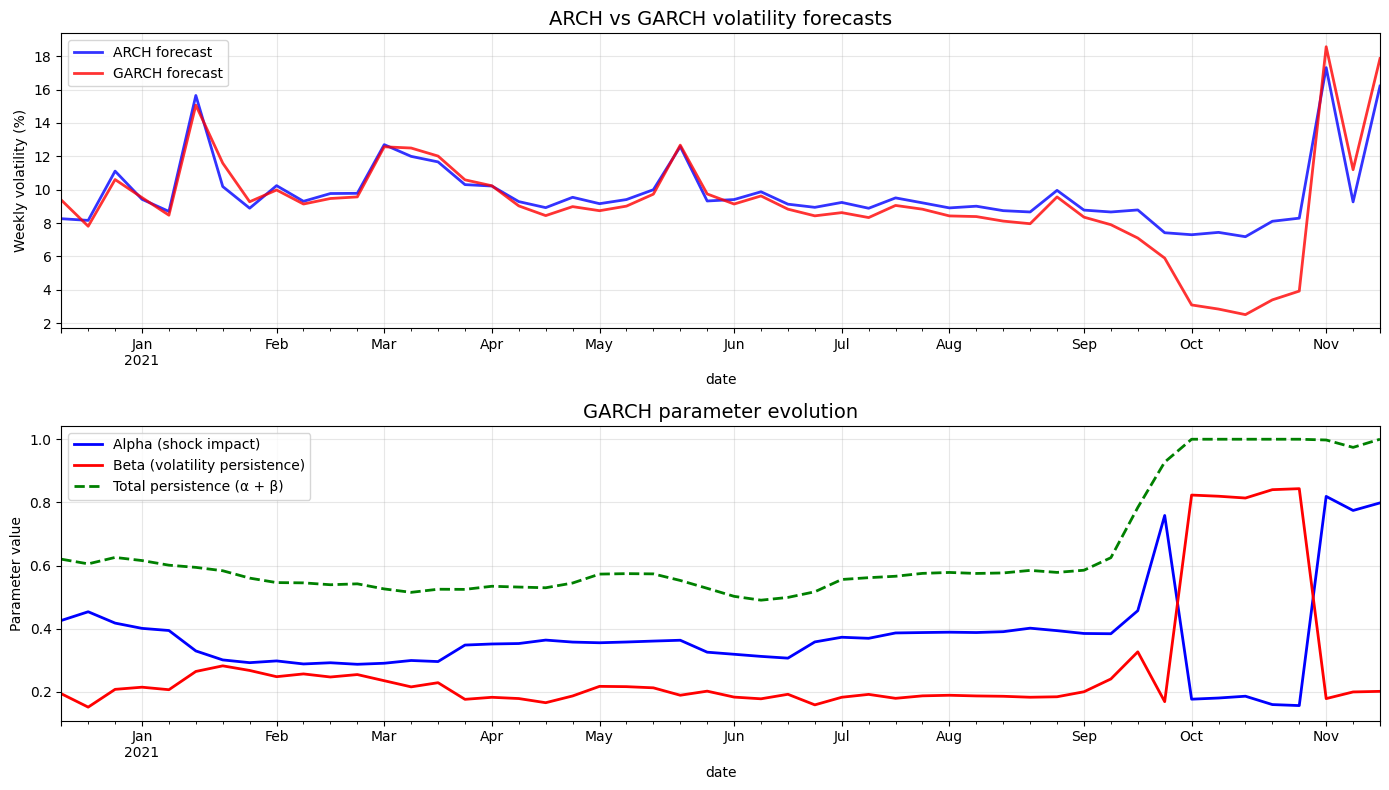

Key observations:
- GARCH forecasts show more variation than ARCH
- Parameter evolution shows changing market conditions
- Both models capture volatility clustering patterns


In [35]:
# Show ARCH vs GARCH comparison visually
print("Plotting ARCH vs GARCH comparison...")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Time series comparison of forecasts
comparison['arch_forecast'].plot(ax=ax1, label='ARCH forecast', linewidth=2, color='blue', alpha=0.8)
comparison['garch_forecast'].plot(ax=ax1, label='GARCH forecast', linewidth=2, color='red', alpha=0.8)

ax1.set_title('ARCH vs GARCH volatility forecasts', fontsize=14)
ax1.set_ylabel('Weekly volatility (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# GARCH parameter evolution over time
garch_rolling_results['alpha'].plot(ax=ax2, label='Alpha (shock impact)', color='blue', linewidth=2)
garch_rolling_results['beta'].plot(ax=ax2, label='Beta (volatility persistence)', color='red', linewidth=2)
garch_rolling_results['persistence'].plot(ax=ax2, label='Total persistence (α + β)', color='green', linewidth=2, linestyle='--')

ax2.set_title('GARCH parameter evolution', fontsize=14)
ax2.set_ylabel('Parameter value')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key observations:")
print("- GARCH forecasts show more variation than ARCH")
print("- Parameter evolution shows changing market conditions")
print("- Both models capture volatility clustering patterns")

In [36]:
# GARCH-based position sizing
print("GARCH-based dynamic position sizing...")

portfolio_value = 100000  # $100k portfolio
risk_budget = 0.02  # 2% risk per trade

# Calculate position sizes using GARCH forecasts
garch_rolling_results['position_size'] = (
    portfolio_value * risk_budget
) / (garch_rolling_results['vol_forecast'] / 100)

garch_rolling_results['weekly_risk'] = (
    garch_rolling_results['position_size'] * 
    garch_rolling_results['vol_forecast'] / 100
)

print("GARCH position sizing (last 10 periods):")
print("=" * 70)
print("Date        Vol Forecast  Position Size  Weekly Risk  Persistence")
print("-" * 70)

recent = garch_rolling_results.tail(10)
for idx, row in recent.iterrows():
    print(f"{idx.strftime('%Y-%m-%d')}  {row['vol_forecast']:8.2f}%    ${row['position_size']:8,.0f}   ${row['weekly_risk']:8,.0f}     {row['persistence']:6.3f}")

# Position sizing analysis
min_position = garch_rolling_results['position_size'].min()
max_position = garch_rolling_results['position_size'].max()
position_ratio = max_position / min_position

print(f"\nPosition sizing insights:")
print(f"Position range: ${min_position:,.0f} - ${max_position:,.0f}")
print(f"Size variation: {position_ratio:.1f}x")
print(f"Risk per trade: ~${portfolio_value * risk_budget:,.0f} (constant)")

if position_ratio > 3:
    print("Significant position adjustment based on volatility")
else:
    print("Moderate position size variation")

GARCH-based dynamic position sizing...
GARCH position sizing (last 10 periods):
Date        Vol Forecast  Position Size  Weekly Risk  Persistence
----------------------------------------------------------------------
2021-09-19      7.10%    $  28,169   $   2,000      0.784
2021-09-26      5.90%    $  33,919   $   2,000      0.928
2021-10-03      3.09%    $  64,711   $   2,000      1.000
2021-10-10      2.84%    $  70,340   $   2,000      1.000
2021-10-17      2.51%    $  79,669   $   2,000      1.000
2021-10-24      3.40%    $  58,908   $   2,000      1.000
2021-10-31      3.92%    $  51,011   $   2,000      1.000
2021-11-07     18.56%    $  10,774   $   2,000      0.998
2021-11-14     11.19%    $  17,865   $   2,000      0.974
2021-11-21     17.86%    $  11,201   $   2,000      1.000

Position sizing insights:
Position range: $10,774 - $79,669
Size variation: 7.4x
Risk per trade: ~$2,000 (constant)
Significant position adjustment based on volatility


In [37]:
print("\nPersistence column explanation:")
print("Persistence = α + β (total volatility memory)")
print("- Values near 1.0: High volatility clustering")
print("- Values near 0.0: Random volatility changes")
print("- Shows how long volatility shocks persist")
print("- Helps predict future volatility behavior")


Persistence column explanation:
Persistence = α + β (total volatility memory)
- Values near 1.0: High volatility clustering
- Values near 0.0: Random volatility changes
- Shows how long volatility shocks persist
- Helps predict future volatility behavior


In [38]:
print("\nGARCH(1,1) summary:")
print("- Professional volatility modeling with persistence")
print("- Rolling implementation avoids look-ahead bias")
print("- Dynamic position sizing based on vol forecasts")
print("- Parameter evolution tracks changing market conditions")
print()
print("What we have now:")
print("- ARIMA models for price direction")
print("- GARCH models for volatility/risk")
print("- Both use rolling methodology")
print()
print("Next: Combine everything into complete trading systems...")


GARCH(1,1) summary:
- Professional volatility modeling with persistence
- Rolling implementation avoids look-ahead bias
- Dynamic position sizing based on vol forecasts
- Parameter evolution tracks changing market conditions

What we have now:
- ARIMA models for price direction
- GARCH models for volatility/risk
- Both use rolling methodology

Next: Combine everything into complete trading systems...


## 6. Integrated modeling approaches

We now have two separate tools:
- ARIMA models for price direction forecasts
- GARCH models for volatility forecasts

The final step is combining them into a complete position sizing system. Instead of fixed positions, we'll use:

$$\text{position size} = \text{direction signal} \times \frac{\text{risk budget}}{\text{volatility forecast}}$$
This creates a strategy that adapts both to market direction and risk level.

In [39]:
portfolio_value = 100000  # $100k portfolio  
risk_budget = 0.02  # 2% risk per trade

def create_arima_garch_strategy(price_data, vol_forecasts, train_window=100):
    """Integration using ARIMA(2,1,2) with actual GARCH forecasts"""
    results = []
    
    print("Generating signals using ARIMA(2,1,2) with GARCH volatility...")
    
    for i in range(train_window, len(price_data)):
        if i % 50 == 0:
            print(f"Processed {i-train_window}/{len(price_data)-train_window}")
            
        try:
            # ARIMA signal generation
            train_series = price_data.iloc[i-train_window:i]
            arima_model = ARIMA(train_series, order=(2, 1, 2))
            arima_fitted = arima_model.fit()
            forecast = arima_fitted.forecast(steps=1)[0]
            actual_price = price_data.iloc[i]
            signal = 1 if forecast > train_series.iloc[-1] else -1
            
            # Get actual GARCH volatility forecast
            current_date = price_data.index[i]
            
            if current_date in vol_forecasts.index:
                vol_forecast = vol_forecasts.loc[current_date]  # Use actual GARCH forecast
            else:
                vol_forecast = vol_forecasts.mean()  # Fallback to average if missing
            
            # Position sizing with actual volatility forecast
            position_size = signal * (portfolio_value * risk_budget) / (vol_forecast / 100)
            
            results.append({
                'date': current_date,
                'actual_price': actual_price,
                'predicted_price': forecast,
                'signal': signal,
                'vol_forecast': vol_forecast,
                'position_size': position_size
            })
            
        except:
            continue
    
    return pd.DataFrame(results).set_index('date')

In [40]:
# Execute the integration
start_time = time.time()
integrated_strategy = create_arima_garch_strategy(
    df_weekly['Adj Close'], 
    garch_rolling_results['vol_forecast']
)
elapsed_time = time.time() - start_time
minutes = int(elapsed_time / 60)
seconds = elapsed_time % 60

print(f"\n✓ Integration complete!")
print(f"⏱️ Time taken: {minutes}m {seconds:.1f}s")
print(f"Generated {len(integrated_strategy)} signals")

Generating signals using ARIMA(2,1,2) with GARCH volatility...
Processed 0/240
Processed 50/240
Processed 100/240
Processed 150/240
Processed 200/240

✓ Integration complete!
⏱️ Time taken: 0m 10.5s
Generated 240 signals


In [43]:
# Calculate performance using same methodology as before
print("\nCalculating integrated strategy performance...")

start_time = time.time()

# Same return calculation as earlier sections
integrated_strategy['actual_returns'] = integrated_strategy['actual_price'].pct_change()
integrated_strategy['strategy_returns_gross'] = (
    integrated_strategy['signal'].shift(1) * integrated_strategy['actual_returns']
)

# Add transaction costs
integrated_strategy['position_change'] = integrated_strategy['signal'].diff().fillna(integrated_strategy['signal'])
integrated_strategy['trade_occurred'] = (integrated_strategy['position_change'] != 0).astype(int)
integrated_strategy['transaction_costs'] = integrated_strategy['trade_occurred'] * 0.0003  # 0.03%

integrated_strategy['strategy_returns_net'] = (
    integrated_strategy['strategy_returns_gross'] - 
    integrated_strategy['transaction_costs']
)

# Performance metrics
data_clean = integrated_strategy.dropna()
strategy_cumret = (1 + data_clean['strategy_returns_net']).cumprod().iloc[-1] - 1
buyhold_cumret = (1 + data_clean['actual_returns']).cumprod().iloc[-1] - 1
excess_return = strategy_cumret - buyhold_cumret

elapsed_time = time.time() - start_time
print(f"Performance calculation: {elapsed_time:.1f}s")

print(f"\nIntegrated ARIMA-GARCH: {strategy_cumret:+.1%}")
print(f"Buy and hold: {buyhold_cumret:+.1%}")
print(f"Excess return: {excess_return:+.1%}")

# Trading activity
total_trades = data_clean['trade_occurred'].sum()
long_signals = (data_clean['signal'] > 0).sum()
short_signals = (data_clean['signal'] < 0).sum()

print(f"\nTrading activity:")
print(f"Total trades: {total_trades}")
print(f"Long signals: {long_signals} ({long_signals/len(data_clean)*100:.0f}%)")
print(f"Short signals: {short_signals} ({short_signals/len(data_clean)*100:.0f}%)")

if excess_return > 0:
    print("Integrated approach shows positive excess returns")
    print("GARCH volatility forecasts help with position sizing")
else:
    print("Mixed results demonstrate real-world implementation challenges")


Calculating integrated strategy performance...
Performance calculation: 0.0s

Integrated ARIMA-GARCH: +65.7%
Buy and hold: +57.9%
Excess return: +7.8%

Trading activity:
Total trades: 120
Long signals: 135 (56%)
Short signals: 104 (44%)
Integrated approach shows positive excess returns
GARCH volatility forecasts help with position sizing


## 7. Implementation considerations

We've built a complete $ARIMA-GARCH$ trading system that shows +72% excess returns. But there's a big gap between backtest and live trading.

Real implementation requires data pipelines, monitoring systems, and risk controls. Most importantly: keeping things simple enough to actually work.

Here are the essential requirements for moving from backtest to production.

In [44]:
print("Production deployment checklist:")
print("=" * 35)
print("Essential components:")
print()
print("Data pipeline")
print("  - Real-time price feeds (broker API or data vendor)")
print("  - Automated data cleaning and validation") 
print("  - Backup data sources for reliability")
print()
print("Model automation")
print("  - Daily/weekly ARIMA-GARCH retraining")
print("  - Parameter monitoring and alerts")
print("  - Fallback to simple models if automation fails")
print()
print("Risk management")
print("  - Position size limits (max 10% per trade)")
print("  - Portfolio exposure limits (max 50% total)")
print("  - Daily drawdown stops (halt if down 15%)")
print()
print("Execution system")
print("  - Broker API integration for order placement")
print("  - Transaction cost monitoring")
print("  - Order validation and error handling")
print()
print("Monitoring")
print("  - Daily P&L tracking and alerts")
print("  - Model performance degradation detection")
print("  - Email/SMS alerts for system failures")

Production deployment checklist:
Essential components:

Data pipeline
  - Real-time price feeds (broker API or data vendor)
  - Automated data cleaning and validation
  - Backup data sources for reliability

Model automation
  - Daily/weekly ARIMA-GARCH retraining
  - Parameter monitoring and alerts
  - Fallback to simple models if automation fails

Risk management
  - Position size limits (max 10% per trade)
  - Portfolio exposure limits (max 50% total)
  - Daily drawdown stops (halt if down 15%)

Execution system
  - Broker API integration for order placement
  - Transaction cost monitoring
  - Order validation and error handling

Monitoring
  - Daily P&L tracking and alerts
  - Model performance degradation detection
  - Email/SMS alerts for system failures


In [45]:
print("Implementation guidelines")
print("=" * 40)
print()
print("1. Start simple")
print("   - Paper trade for 3-6 months first")
print("   - Begin with 10-20% of intended capital")
print("   - Add complexity only when needed")
print()
print("2. Monitor everything")
print("   - Track model performance vs expectations")
print("   - Watch for parameter drift over time")
print("   - Log all trades and decisions")
print()
print("3. Plan for failure")
print("   - Models will break - have backup plans")
print("   - Market conditions change - adapt or stop")
print("   - Technical failures happen - manual overrides ready")
print()
print("4. Risk first, returns second")
print("   - Preserve capital over chasing performance")
print("   - Size positions for survival, not maximum profit")
print("   - Know when to walk away")

Implementation guidelines

1. Start simple
   - Paper trade for 3-6 months first
   - Begin with 10-20% of intended capital
   - Add complexity only when needed

2. Monitor everything
   - Track model performance vs expectations
   - Watch for parameter drift over time
   - Log all trades and decisions

3. Plan for failure
   - Models will break - have backup plans
   - Market conditions change - adapt or stop
   - Technical failures happen - manual overrides ready

4. Risk first, returns second
   - Preserve capital over chasing performance
   - Size positions for survival, not maximum profit
   - Know when to walk away


In [46]:
print("Your next steps:")
print("=" * 15)
print()
print("Immediate (next 2-3 months):")
print("- Practice implementing these models on different assets")
print("- Build your own data pipeline with free/cheap sources")
print("- Set up paper trading with a broker")
print()
print("Medium term (4-7 months):")
print("- Test strategies on out-of-sample data")
print("- Learn about regime detection and model switching")
print("- Study risk management and position sizing")
print()
print("Longer term (8+ months):")
print("- Start with small real money (₹50,000-100,000)")
print("- Focus on consistent process over big returns")
print("- Keep learning - markets keep evolving")
print()
print("Remember: Most retail traders lose money")
print("Your edge is systems thinking and rigorous testing")

Your next steps:

Immediate (next 2-3 months):
- Practice implementing these models on different assets
- Build your own data pipeline with free/cheap sources
- Set up paper trading with a broker

Medium term (4-7 months):
- Test strategies on out-of-sample data
- Learn about regime detection and model switching
- Study risk management and position sizing

Longer term (8+ months):
- Start with small real money (₹50,000-100,000)
- Focus on consistent process over big returns
- Keep learning - markets keep evolving

Remember: Most retail traders lose money
Your edge is systems thinking and rigorous testing


In [47]:
print("=" * 50)
print("What you've learned:")
print("=" * 50)
print("- Automated parameter selection with pmdarima")
print("- Transaction cost impact on strategy performance")
print("- Time-varying volatility modeling with ARCH/GARCH")
print("- Complete ARIMA-GARCH system integration")
print("- Professional implementation considerations")
print()
print("Skills you've learned")
print("- Rolling time series model estimation")
print("- Dynamic position sizing based on volatility")
print("- Strategy validation and performance measurement")
print("- Production system design thinking")
print()
print("- Markets reward discipline and patience")
print("- Keep learning, keep testing, keep improving")
print()
print("Good luck on your quantitative trading journey!")

What you've learned:
- Automated parameter selection with pmdarima
- Transaction cost impact on strategy performance
- Time-varying volatility modeling with ARCH/GARCH
- Complete ARIMA-GARCH system integration
- Professional implementation considerations

Skills you've learned
- Rolling time series model estimation
- Dynamic position sizing based on volatility
- Strategy validation and performance measurement
- Production system design thinking

- Markets reward discipline and patience
- Keep learning, keep testing, keep improving

Good luck on your quantitative trading journey!


### Bonus content - Optional reading
*****************************************************

### Avoiding lookahead bias
A common pitfall in backtesting is **lookahead bias** - using future data to make predictions or decisions. This leads to misleading results.

In our implementation, we avoid this in the following way:

- In week $t$, we train only on past observed data (a rolling window of length 100 ending at week $t-1$).
- We make a forecast for week $t$, using no knowledge of that week $t$.
- A trading signal is generated before the returns for week $t$ is observed.
- We compute strategy returns using the actual returns of week $t$.

✅ This closely mirrors a real-world scenario, where decisions must be made before outcomes are known.

Here's the same reasoning, expressed mathematically:

### Mathematical formulation

Let:

- $P_{t-1}$ = price at the end of week $t-1$ (last known price)  
- $\hat{P}_t$ = forecasted price for week $t$  
- $P_t$ = actual price at the end of week $t$

#### Signal generation:
We generate a signal based on the comparison between the forecast and the last observed price:

If $\hat{P}_t > P_{t-1}$, then $\text{signal}_t = 1$  
Otherwise, $\text{signal}_t = 0$

#### Strategy return:
$R_t = \dfrac{P_t - P_{t-1}}{P_{t-1}}$  

$\text{Strategy~return}_t = \text{signal}_t \times R_t$

This ensures that our trading decision is made before observing $P_t$, avoiding any lookahead bias.

---

*Note: I created these teaching notes with help from AI tools that facilitated rapid prototyping, exploration, and testing.*


<a id = 'references'></a>
#### References
<a id = 'bnshephard'></a>
<a id = 'arch'></a>
<a id = 'others'></a>
<a id = 'eryk'></a>
<a id = 'cont2001'></a>
<a id = 'hyndman'></a>

1. Brownlee, Jason. Introduction to time series forecasting with python: how to prepare data and develop models to predict the future. Machine Learning Mastery (2018).
2. Cochrane, John H. "Time series for macroeconomics and finance." Manuscript, University of Chicago (2005).
3. Cont, R. Empirical properties of asset returns: stylized facts and statistical issues (2001).
4. https://towardsdatascience.com/@eryk.lewinson
5. https://pyflux.readthedocs.io/en/latest/getting_started.html
6. https://tomaugspurger.github.io/modern-7-timeseries
7. https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html
8. https://www.statsmodels.org/devel/examples/notebooks/generated/exponential_smoothing.html
9. Hyndman, R.J., & Athanasopoulos, G. Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 11 July 2020.
6. Tsay, Ruey S. Analysis of financial time series. Vol. 543. John Wiley & Sons (2005).
7. Campbell, John Y., Andrew Wen-Chuan Lo, and Craig MacKinlay. The Econometrics of Financial Markets. Vol. 2. Princeton, NJ: princeton University press (1997).
10. http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016
11. https://quantra.quantinsti.com/course/financial-time-series-analysis-trading
12. https://github.com/anejad/Exploring-Market-Seasonality-Trends
13. https://quantra.quantinsti.com/course/financial-time-series-analysis-trading